In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
import numpy as np
import pandas as pd
import os, sys
import shutil
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
import cv2
from imgaug import augmenters as iaa
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
from sklearn.utils import class_weight, shuffle
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from sklearn.model_selection import train_test_split
import warnings
import shutil

In [118]:
'''
pixel in the image should be value [0,255]
'''
import tensorflow as tf
import numpy as np

class Transformation(object):
    def __init__(self):
        pass
    def __call__(self,image):
        return image

class Resize(Transformation):
    '''
        method - one of the tf.image.ResizeMethod
    '''
    def __init__(self, size = None, method = tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio = False, antialias = False):
        self.method = method
        self.preserve_aspect_ratio = preserve_aspect_ratio
        self.antialias = antialias
        self.size = size
    def __call__(self,image = None):
        if self.size is None or image is None:
            return None
        return tf.image.resize(image, self.size, method=self.method, 
                               preserve_aspect_ratio=self.preserve_aspect_ratio, 
                               antialias=self.antialias, name=None).numpy()
class Cropp(Transformation):
    def __init__(self, tolerance = None):
        self.tolerance = tolerance
    def __call__(self,image = None):
        if image is None or self.tolerance is None:
            return None
        return self.__cropImage__(image)
    def __cropImage__(self, image):
        grayImage = tf.image.rgb_to_grayscale(image)
        mask = tf.greater(grayImage, self.tolerance)
        rows = tf.reshape(tf.reduce_any(mask,1), (-1,1))
        r_sz = tf.reduce_sum(tf.cast(rows,tf.int32));
        cols = tf.reshape(tf.reduce_any(mask,0),(1,-1))
        c_sz = tf.reduce_sum(tf.cast(cols,tf.int32))
        if c_sz == 0 or r_sz == 0:
            return image
        mask = tf.logical_and(rows,cols)
        newImage = []
        for i in [0,1,2]:
            newImage.append(tf.reshape(tf.boolean_mask(image[:,:,i],mask),(r_sz,c_sz)))
        return tf.stack(newImage,axis = 2).numpy()
    
class Sharppen(Transformation):
    def __init__(self, sigma = None):
        self.sigma = sigma
    def __call__(self, image = None):
        if image is None or self.sigma is None:
            return None
        img = cv2.addWeighted ( image,4, cv2.GaussianBlur( image, (0,0) , self.sigma) ,-4 ,128)
        return img
    
class CircleMask(Transformation):
    def __call__(self,image):
        height, width, depth = image.shape    
        x = int(width/2)
        y = int(height/2)
        r = np.amin((x,y))
        circle_img = np.zeros((height, width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        return cv2.bitwise_and(image, image, mask=circle_img)

class AddGauseNoise(Transformation):
    def __init__(self,supperSigma = 1):
        super().__init__()
        self.SupperSigma = supperSigma
        
    def __call__(self, image):
        sigmav = np.random.choice(self.SupperSigma, 3)
        noise = np.random.normal(0,sigmav,image.shape)
        return np.clip(noise + image,0.,255.)
    
class RandomVisualEffect(Transformation):
    def __init__(self):
        super().__init__()
        self.rot = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE,cv2.ROTATE_180]
    
    def __call__(self, image):
        rix = np.random.choice(3,1)[0]
        image = cv2.rotate(image,self.rot[rix])
        image = tf.image.adjust_contrast(image, 1.0 + 2.0 * np.random.random())
        image = tf.image.random_hue(image,0.5)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        return image.numpy()
    
class CompositTransformation(Transformation):
    def __init__(self,trans = None):
        self.trans = trans
    def __call__(self,image):
        if self.trans is None or image is None:
            return None
        for tr in self.trans:
            image = tr(image)
        return image
    
class ImagePreprocessing(object):
    def __init__(self, transforms = Transformation()):
        self.transforms = transforms
        self.oimg = None
        self.timg = None
        
    def __call__(self,path):
        if self.transforms is None:
            return None
        if os.path.isfile(path):
            print(path)
            self.oimg = cv2.imread(path)
            self.timg = self.oimg
        else:
            return None
        self.timg = self.transforms(self.oimg).astype('uint8')
        return self.timg
    
    def ShowImages(self):
        fig = plt.figure(figsize=(16,16))
        fig.add_subplot(1,2,1)
        plt.imshow(self.oimg)
        fig.add_subplot(1,2,2)
        plt.imshow(self.timg)

In [ ]:
tr1 = Resize(size = (224,224),preserve_aspect_ratio = True)
tr2 = CircleMask()
tr3 = Cropp(7)
tr4 = Sharppen(128)
trans = CompositTransformation([tr2,tr3,tr4])
imgproc = ImagePreprocessing(trans)
path = r'C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\aptos_2019\data\raw\train_images\0b3efe669365.png'
imgproc(path)
imgproc.ShowImages()

In [276]:
class A(object):
    def __init__(self):
        pass
    def __call__(self,arg):
        return 13
    
class B(object):
    def __init__(self):
        pass
    def __call__(self,arg):
        return 7
    
class C(B,A):
    def __init__(self):
        super().__init__()
        
    def __call__(self,arg):
        if arg >= 0:
            return arg
        return super().__call__(arg)



In [281]:
v = None
np.array(v).astype('uint8')

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\aptos_2019\data\raw\train_images\0b3efe669365.png


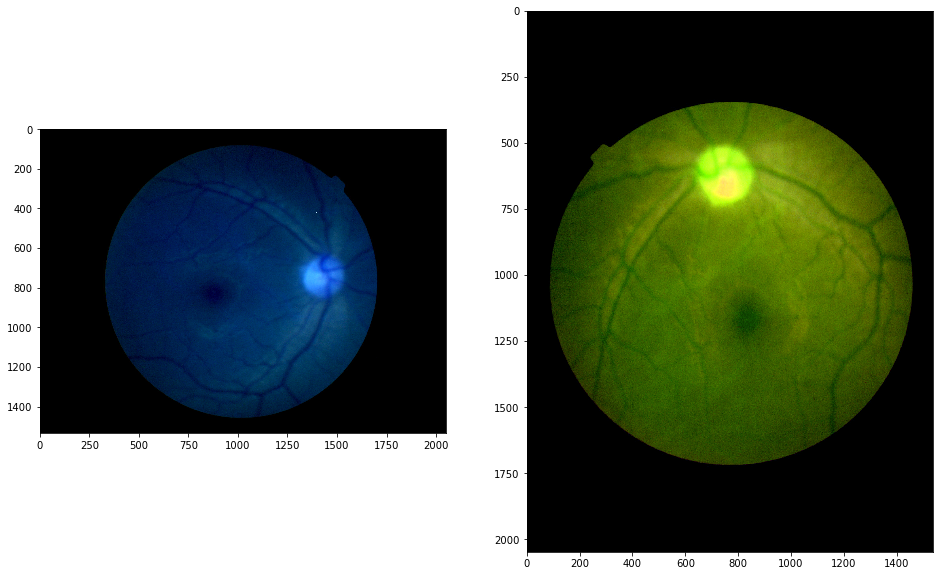

In [266]:
tr1 = Resize((224,224))
tr2 = RandomRotate()
tr = CompositTransformation([tr1,tr2])
tr = RandomVisualEffect()
imgproc = ImagePreprocessing(tr)
path = r'C:\Users\PLDD\Practice\GitHub\Python\ML\Kaggle\aptos_2019\data\raw\train_images\0b3efe669365.png'
imgproc(path)
imgproc.ShowImages()

In [246]:
img.dtype

dtype('uint8')

In [ ]:
t1 = tf.ones((2,2))
t2 = tf.ones((2,2))

In [ ]:
@tf.function
def foo(t1, t2):
    return t1 + t2

In [ ]:
t = foo(t1, t2)

In [ ]:
sess = tf.compat.v1.Session()
sess.run(t)